### 173 samples, Final_R is missing for the following sample
137)	MC	air	204	8	180	60	180	500	30	114	0.3	NA	150	0.3	100	0.490196078	486.395	57.78712883	26.00664167	0.467	9.68631173	3	0.422680412	0.541775715	0.521526486	44.36424367

In [1]:
# Import Python libaries
%matplotlib inline

import time as time
# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)

# Machine learning & model visualization tools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc
import pydot
import math
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.inspection import partial_dependence, plot_partial_dependence

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2022-09-04 07:19:21.234455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-04 07:19:21.234476: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [19]:
dropped = ['Mass', 'Init_R', 'Fin_R', 'Voltage', 'Res_Volt', 'PulseTime_I', 'I_Mean']
def import_file(filename):
    # Convert to pandas dataframe & take a look
    # filename='FJH_ML.csv'
    df = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=1)
    # df = df.drop('Unnamed: 27', axis=1)
    # df = df.drop('Unnamed: 28', axis=1)
    # df = df.drop('Unnamed: 29', axis=1)
    df = df.dropna()
    # Convert numerical columns to float
    interest = ['Mass', 'Pretreat_voltage', 'Pretreat_highest', 'Voltage', 'PulseTime', 'Cap', 
                'Res_Volt', 'Init_R', 'Fin_R', 'Volt_Drop', 'Res_Drop', 'Yield_Per', 'I_Max', 
                'I_Mean', 'Charge_Tot', 'PulseTime_I', 'I_Final', 'Maxima', 'Graphene_Yield', 
                'TwoDtoG', 'DtoG', 'FWHM 2D']
    for i in range(0, len(interest)):
        col = interest[i]
        df[col] = df[col].astype(float)
    # Fix percentages
    df['Graphene_Yield'] = df['Graphene_Yield']*100
    df['Yield_Per'] = df['Yield_Per']*100
    
    
    
    # Drop problematic data for this particular analysis
    dropped_features = [ 'Res_Drop',
             'PulseTime_I', 'I_Mean', 'Maxima']
    df = df.drop(dropped_features, axis=1)
    
    
    
    # df = df[df['Yield_Per']>50]
    # Also drop asinine variables
    
    #df = df.drop('Map File ID', axis = 1)
    df = df.drop('Tube Diam', axis = 1)

    # categorize_yield(df)
    # One-hot encode the data using pandas get_dummies
    df = pd.get_dummies(df)
    # df = df[df['Material_CB']>0.5]
    # Drop 1 thing
    # df = df.drop['']
    # Dataset is now stored in a Pandas Dataframe
    # print(df.shape)
    # print(df.head())
    # print(df.isnull().sum())
    return df

def import_file_noOneHot(filename):
# Convert to pandas dataframe & take a look
    # filename='FJH_ML.csv'
    df = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=1)
    # df = df.drop('Unnamed: 27', axis=1)
    # df = df.drop('Unnamed: 28', axis=1)
    # df = df.drop('Unnamed: 29', axis=1)
    df = df.dropna()
    # Convert numerical columns to float
    interest = ['Mass', 'Pretreat_voltage', 'Pretreat_highest', 'Voltage', 'PulseTime', 'Cap', 
                'Res_Volt', 'Init_R', 'Fin_R', 'Volt_Drop', 'Res_Drop', 'Yield_Per', 'I_Max', 
                'I_Mean', 'PulseTime_I', 'I_Final', 'Maxima', 'Graphene_Yield', 'TwoDtoG', 'DtoG', 'FWHM 2D']
    for i in range(0, len(interest)):
        col = interest[i]
        df[col] = df[col].astype(float)
    # Fix percentages
    df['Graphene_Yield'] = df['Graphene_Yield']*100
    df['Yield_Per'] = df['Yield_Per']*100
    # Drop problematic data for this particular analysis
    # df = df[df['Yield_Per']>50]
    # Also drop asinine variables
    try:
        df = df.drop('Map File ID', axis = 1)
    except:
        pass
    df = df.drop('Tube Diam', axis = 1)
    # categorize_yield(df)
    # One-hot encode the data using pandas get_dummies
    # df = pd.get_dummies(df)
    # df = df[df['Material_CB']>0.5]
    # Drop 1 thing
    # df = df.drop['']
    # Dataset is now stored in a Pandas Dataframe
    # print(df.shape)
    # print(df.head())
    # print(df.isnull().sum())
    return df

def categorize_yield(df):
    yield_cat = []
    for i in range(0, len(df)):
        if df['Graphene_Yield'][i] < 30:
            yield_cat.append(0)
        else:
            yield_cat.append(1)
    print(len(df))
    print(len(yield_cat))
    df['Yield_Cat'] = yield_cat
    return df['Yield_Cat']
    
def leave_one_out_proc(clf):
    # Leave one out evaluation
    # enumerate splits
    y_true, y_pred = list(), list()
    # Create leave one out procedure
    cv = LeaveOneOut()
    for train_ix, test_ix in cv.split(features):
        # split data
        train_features, test_features = features[train_ix, :], features[test_ix, :]
        train_labels, test_labels = labels[train_ix], labels[test_ix]
        clf.fit(train_features, train_labels)
        # evaluate model
        yhat = clf.predict(test_features)
        # store
        y_true.append(test_labels[0])
        y_pred.append(yhat[0])
    print('doneskies')
    return y_true, y_pred, clf

def category_normalization_theonesyoualwaysuse(df):
    groups = df.groupby(['Material'])
    norm_I_Max = []
    norm_charge_tot=[]
    for name, group in groups:
        I_Max_array = np.asfarray(group.I_Max)
        charge_tot_array = np.asfarray(group.Charge_Tot)
        mean_I_Max = np.mean(I_Max_array)
        mean_charge_tot = np.mean(charge_tot_array)
        std_I_Max = np.std(I_Max_array)
        std_charge_tot = np.std(charge_tot_array)
        print("Mean of I Max", name, "is ", mean_I_Max)
        norm_I_Max_cat = np.divide(np.subtract(I_Max_array, mean_I_Max), std_I_Max)
        norm_charge_tot_cat = np.divide(np.subtract(charge_tot_array, mean_charge_tot), std_charge_tot)
        norm_I_Max = np.append(norm_I_Max, norm_I_Max_cat)
        norm_charge_tot = np.append(norm_charge_tot, norm_charge_tot_cat)
    return norm_I_Max, norm_charge_tot

def category_normalization_mass(df):
    groups = df.groupby(['Material'])
    norm_array = []
    for name, group in groups:
        yield_array = np.asfarray(group.Mass)
        mean_yield = np.mean(yield_array)
        std_yield = np.std(yield_array)
        print("Mean of ", name, "is ", mean_yield)
        norm_yield_cat = np.divide(np.subtract(yield_array, mean_yield), std_yield)
        norm_array = np.append(norm_array, norm_yield_cat)
    return norm_array

findfont: Font family ['Time'] not found. Falling back to DejaVu Sans.


Mean of I Max CB is  199.5962952631579
Mean of I Max MC is  548.2808046511627
Mean of I Max PA is  301.9472116666666
Mean of I Max TCB is  217.5159437837838


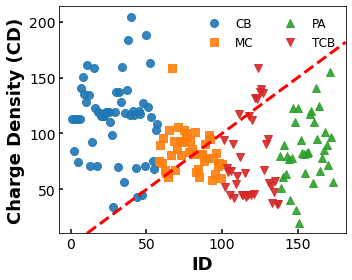

In [29]:
# Plot charge density (CD) for different materials 
fig, ax = plt.subplots(figsize=(5,4))
# Import file
filename='FJH_ML_Final.csv'
df_nothotenc = import_file_noOneHot(filename)
# Create normalized I by category
norm1, norm2 = category_normalization_theonesyoualwaysuse(df_nothotenc)
df_nothotenc['Norm_I_Max'] = norm1
df_nothotenc['Norm_charge_tot'] = norm2
df_nothotenc['charge_density'] = df_nothotenc['Voltage']*df_nothotenc['Cap']/df_nothotenc['Mass']

# df_nothotenc['test_feature'] = (df_nothotenc['Voltage']/df_nothotenc['Mass'])#*df_nothotenc['PulseTime']
# df_nothotenc = df_nothotenc[df_nothotenc['TwoDtoG']<1.5]
# df_nothotenc = df_nothotenc[df_nothotenc['Graphene_Yield']>20]

groups = df_nothotenc.groupby(['Material'])

df_nothotenc['ID'] = list(range(1, df_nothotenc['charge_density'].shape[0]+1))
# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.ID, group.charge_density, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('ID', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Charge Density (CD)', fontsize='18', fontname='Time', fontweight='bold')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper right')

# Plot
# plt.plot(df_nothotenc['I_Max'],df_nothotenc['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')
# Save
plt.tight_layout()
plt.savefig('cvDist_material.png', dpi=300)
plt.show()

In [21]:
# Import file for ML model
filename='FJH_ML_Final.csv'
df1 = import_file_noOneHot(filename)
Imax, chargetot = category_normalization_theonesyoualwaysuse(df1)
yield_array = category_normalization_mass(df1)
df = import_file(filename)
# df['Norm_I_Max'] = Imax
df['Norm_charge_tot'] = df['Charge_Tot']/(df['Mass'])*1000
df['Norm_I_Max'] = df['I_Max']/df['Mass']*1000
# df['Discharge_Rate'] = (df['Volt_Drop']/df['Mass'])/df['PulseTime']
# df['norm_mass'] = yield_array
# df['cap_energy'] = 0.5*df['Voltage']*df['Voltage']*df['Cap']/df['Mass']
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
# df['charge_density2'] = df['Volt_Drop']*df['Cap']/df['Mass']
# df['RC'] = df['Init_R']*df['Cap']
# df['test_feature'] = 1/df['Mass']
df['Final_Current_Percent'] = df['I_Final']/df['I_Max']
# convert it to Mega Joule 1e-5
df['heat_power'] = df['Voltage']*df['Voltage']/df['Init_R']*df['PulseTime']*(1e-5)
# df['discharge_per'] = df['Res_Volt']/df['Voltage']
# df['Pretreat_CD'] = df['Pretreat_highest']*df['Cap']/df['Mass']
# df['inv_Mass'] = 1/df['Mass']
#df['average_res'] = (df['Init_R']+df['Fin_R'])/2
#df['Power'] = df['I_Max']*df['I_Max']*df['average_res']/df['Mass']
# df = df.drop('average_res', axis=1)
# df['test_feature'] = df['Res_Volt']/df['Voltage']
# df = df.drop('norm_mass', axis=1)
# Drop stuff
#df = df.drop('Voltage', axis=1)
#df = df.drop('Res_Volt', axis=1)
# df = df.drop('Norm_I_Max', axis=1)
#df = df.drop('Volt_Drop', axis=1)
#df = df.drop('Mass', axis=1)
#df = df.drop('Cap', axis=1)
#df = df.drop('PulseTime', axis=1)
#df = df.drop('I_Final', axis=1)
#df = df.drop('Fin_R', axis=1)
#df = df.drop('Init_R', axis=1)
#df = df.drop('Pretreat_highest', axis=1)
#df = df.drop('Pretreat_voltage', axis=1)

# Why he droped Material_PA and Material_TCB?
#df = df.drop('Material_PA', axis=1)
#df = df.drop('Material_TCB', axis=1)


# df = df.drop('Norm_charge_tot', axis=1)
#df = df.drop('Charge_Tot', axis=1)
# df = df.drop('Final_Current_Percent', axis=1)
# df = df.drop('charge_density', axis=1)
# df = df.drop('average_res', axis=1)""
#df['FJH_Power'] = df['I_Max']*df['I_Max']*df['Init_R']
# df = df[df['Graphene_Yield']>20]
categorize_yield(df)
# Print stats
print(df.shape)
print(df.head())
# print(len(df))
print(sum(df['Material_MC']))

Mean of I Max CB is  199.5962952631579
Mean of I Max MC is  548.2808046511627
Mean of I Max PA is  301.9472116666666
Mean of I Max TCB is  217.5159437837838
Mean of  CB is  186.9859649122807
Mean of  MC is  276.5790697674419
Mean of  PA is  283.28055555555557
Mean of  TCB is  319.81081081081084


KeyError: 100

In [8]:
df['Graphen_group']

0       746.820500
1       547.293823
2       443.034350
3       513.726500
4       375.748930
          ...     
169    1103.409483
170     924.340645
171    1882.346939
172    1167.779717
173     695.057632
Name: Norm_I_Max, Length: 173, dtype: float64

charge density for group CB is 186.9859649122807
charge density for group MC is 276.5790697674419
charge density for group PA is 283.28055555555557
charge density for group TCB is 319.81081081081084


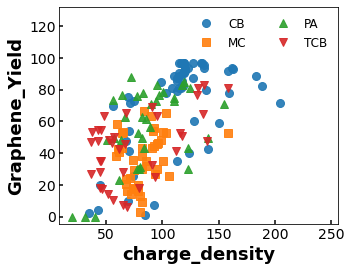

In [30]:
df_currenttime = df
df_currenttime ['materialgroup'] = df_nothotenc['Material']
df_currenttime ['ID'] = list(range(1, df_currenttime['charge_density'].shape[0]+1))
df_currenttime ['Norm_I_Max'] = df['Norm_I_Max']
df_currenttime ['I_Max'] = df['I_Max']
df_currenttime ['I_Final'] = df['I_Final']
df_currenttime ['Charge_Tot'] = df['Charge_Tot']
df_currenttime ['Init_R'] = df['Init_R']
df_currenttime ['I_VdR'] = df['Voltage']/df['Init_R']


groups = df_currenttime.groupby(['materialgroup']) 
 
for name, group in groups:
    print ('charge density for group {} is {}'.
           format(name,  np.mean (np.array (group.Mass))))
# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']

for name, group in groups:
    ax.plot(group.charge_density, group.Graphene_Yield, 
            marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('charge_density', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Graphene_Yield', fontsize='18', fontname='Arial', fontweight='bold')

leg = plt.legend(frameon="True", prop={'family': 'Arial'})


ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
ax.set_xlim(0.8*xmin, 1.2*xmax)
ax.set_ylim(ymin, 1.3*ymax)

ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper right')

charge density for group CB is 186.9859649122807
charge density for group MC is 276.5790697674419
charge density for group PA is 283.28055555555557
charge density for group TCB is 319.81081081081084


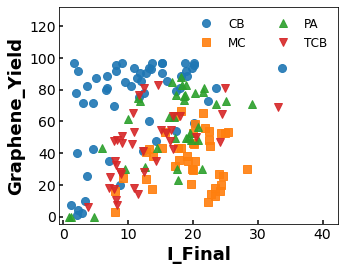

In [34]:
df_currenttime = df
df_currenttime ['materialgroup'] = df_nothotenc['Material']
df_currenttime ['ID'] = list(range(1, df_currenttime['charge_density'].shape[0]+1))
df_currenttime ['Norm_I_Max'] = df['Norm_I_Max']
df_currenttime ['I_Max'] = df['I_Max']
df_currenttime ['I_Final'] = df['I_Final']
df_currenttime ['Charge_Tot'] = df['Charge_Tot']
df_currenttime ['Init_R'] = df['Init_R']
df_currenttime ['I_VdR'] = df['Voltage']/df['Init_R']


groups = df_currenttime.groupby(['materialgroup']) 
 
for name, group in groups:
    print ('charge density for group {} is {}'.
           format(name,  np.mean (np.array (group.Mass))))
# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']

for name, group in groups:
    ax.plot(group.Charge_Tot, group.Graphene_Yield, 
            marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('I_Final', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Graphene_Yield', fontsize='18', fontname='Arial', fontweight='bold')

leg = plt.legend(frameon="True", prop={'family': 'Arial'})


ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
ax.set_xlim(0.8*xmin, 1.2*xmax)
ax.set_ylim(ymin, 1.3*ymax)

ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper right')

In [11]:
df_nothotenc

,Sample,Material,Atmosphere,Mass,Pretreat_voltage,Pretreat_highest,Voltage,PulseTime,Res_Volt,Cap,...,I_Final,Maxima,Graphene_Yield,TwoDtoG,DtoG,FWHM 2D,Norm_I_Max,Norm_charge_tot,charge_density,ID
0,1,CB,vac,200.0,60.0,60.0,235.0,1200.0,56.0,96.0,...,9.502359,3.0,85.714286,0.798070,0.546842,52.940275,-0.516748,0.681503,112.800000,1
1,2,CB,vac,161.9,150.0,50.0,120.0,50.0,98.0,114.0,...,87.808988,1.0,1.010101,0.458187,0.912020,0.000000,-1.141768,-1.332697,84.496603,2
2,3,CB,vac,200.0,240.0,60.0,235.0,300.0,161.0,96.0,...,14.074358,2.0,34.920635,0.650986,0.746614,40.452173,-1.141768,-0.609461,112.800000,3
3,4,CB,vac,200.0,320.0,80.0,235.0,900.0,43.0,96.0,...,10.231751,8.0,79.365079,0.763019,0.661025,50.596165,-0.996323,0.873358,112.800000,4
4,5,CB,air,187.0,60.0,60.0,145.0,125.0,104.6,96.0,...,15.189012,2.0,25.396825,0.646567,0.500579,40.277124,-1.330454,-1.106445,74.438503,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,112,PA,vac,348.0,200.0,120.0,209.0,202.0,77.6,150.0,...,35.656144,2.0,70.707071,0.680551,0.474430,43.150557,-0.815503,-0.354946,90.086207,169
170,113,PA,vac,310.0,210.0,110.0,196.0,179.0,56.1,114.0,...,24.830082,2.0,87.878788,0.765000,0.430418,41.676351,-0.003718,0.807541,72.077419,170
171,114,PA,vac,245.0,300.0,100.0,204.0,305.0,23.2,186.0,...,11.268943,4.0,70.707071,0.665220,0.490516,43.755495,-0.540322,1.218573,154.873469,171
172,115,PA,air,212.0,240.0,100.0,180.0,500.0,73.3,114.0,...,14.435920,5.0,76.923077,0.656134,0.398971,43.757367,0.144879,1.804289,96.792453,172


/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 29.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWar

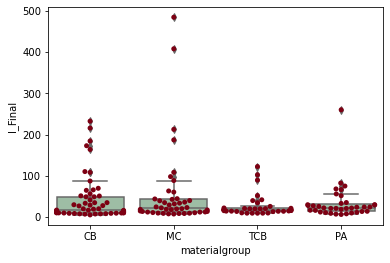

1.7483884632090643 0.15903897708366457


In [6]:
# distribution of I_Final for different materials
import seaborn as sns
interest = 'I_Final'
ax = sns.boxplot(x='materialgroup', y=interest, data=df_currenttime, color='#99c2a2')
ax = sns.swarmplot(x="materialgroup", y=interest, data=df_currenttime, color='#7d0013')
plt.show()

import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='CB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='MC'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='TCB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='PA']
)
print(fvalue, pvalue)


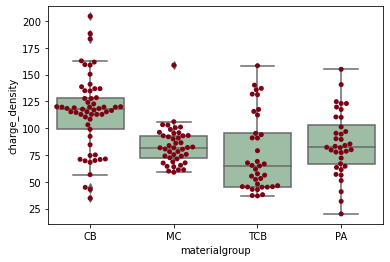

14.83185657621729 1.2873008751562517e-08


In [7]:
# distribution of I_Final for different materials
import seaborn as sns
interest = 'charge_density'
ax = sns.boxplot(x='materialgroup', y=interest, data=df_currenttime, color='#99c2a2')
ax = sns.swarmplot(x="materialgroup", y=interest, data=df_currenttime, color='#7d0013')
plt.show()

import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='CB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='MC'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='TCB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='PA']
)
print(fvalue, pvalue)

In [10]:
df_currenttime[interest].loc[df_currenttime['materialgroup']=='MC']>150

TypeError: '>' not supported between instances of 'str' and 'int'

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 40.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 64.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 63.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


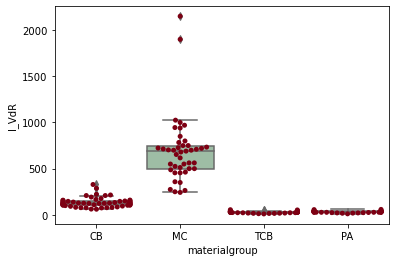

127.05741693026096 4.20265871643418e-43


In [23]:
# distribution of I_Max for different materials
import seaborn as sns
interest = 'I_VdR'
ax = sns.boxplot(x='materialgroup', y=interest, data=df_currenttime, color='#99c2a2')
ax = sns.swarmplot(x="materialgroup", y=interest, data=df_currenttime, color='#7d0013')
plt.show()

import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='CB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='MC'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='TCB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='PA']
)
print(fvalue, pvalue)

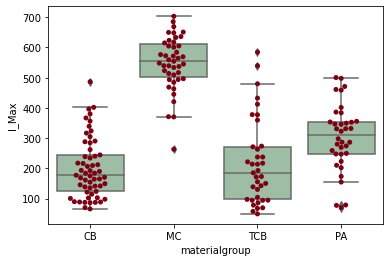

96.65203018968828 1.804355019338001e-36


In [24]:
# distribution of I_Max for different materials
import seaborn as sns
interest = 'I_Max'
ax = sns.boxplot(x='materialgroup', y=interest, data=df_currenttime, color='#99c2a2')
ax = sns.swarmplot(x="materialgroup", y=interest, data=df_currenttime, color='#7d0013')
plt.show()

import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='CB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='MC'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='TCB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='PA']
)
print(fvalue, pvalue)

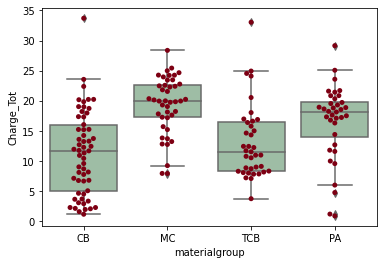

15.561396697450448 5.535774294744195e-09


In [11]:
# distribution of I_Max for different materials
import seaborn as sns
interest = 'Charge_Tot'
ax = sns.boxplot(x='materialgroup', y=interest, data=df_currenttime, color='#99c2a2')
ax = sns.swarmplot(x="materialgroup", y=interest, data=df_currenttime, color='#7d0013')
plt.show()

import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='CB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='MC'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='TCB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='PA']
)
print(fvalue, pvalue)

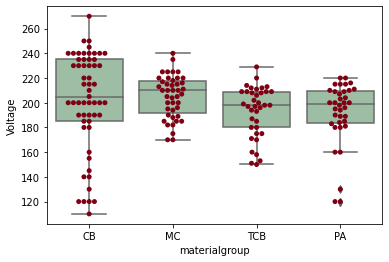

2.1222004486553563 0.09927520133327057


In [12]:
# distribution of Voltage for different materials
import seaborn as sns
interest = 'Voltage'
ax = sns.boxplot(x='materialgroup', y=interest, data=df_currenttime, color='#99c2a2')
ax = sns.swarmplot(x="materialgroup", y=interest, data=df_currenttime, color='#7d0013')
plt.show()

import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='CB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='MC'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='TCB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='PA']
)
print(fvalue, pvalue)

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 29.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 55.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


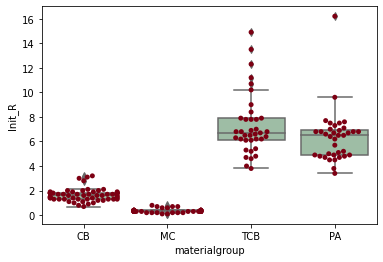

202.48008951567377 1.0174241993395109e-55


In [13]:
# distribution of Init_R for different materials
import seaborn as sns
interest = 'Init_R'
ax = sns.boxplot(x='materialgroup', y=interest, data=df_currenttime, color='#99c2a2')
ax = sns.swarmplot(x="materialgroup", y=interest, data=df_currenttime, color='#7d0013')
plt.show()

import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='CB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='MC'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='TCB'], 
    df_currenttime[interest].loc[df_currenttime['materialgroup']=='PA']
)
print(fvalue, pvalue)

In [11]:
# proxy properties
Norm_I_Max = np.array (df['I_Max']).reshape(-1, 1)
Final_Current_Percent  = np.array (df['Final_Current_Percent']).reshape(-1, 1)
Norm_charge_tot  = np.array (df['Norm_charge_tot']).reshape(-1, 1)
# final prediction, yield of Graphene
Graphene_Yield = np.array (df['Graphene_Yield']).reshape(-1, 1)

# only process parameters
Pretreat_voltage = np.array (df['Pretreat_voltage']).reshape(-1, 1)
pulsetime = np.array (df['PulseTime']).reshape(-1, 1)
charge_denisty = np.array (df['charge_density']).reshape(-1, 1)
heat_power = np.array (df['heat_power']).reshape(-1, 1)
#Init_R = np.array (df['Init_R']).reshape(-1, 1)

#features = np.asfarray(features)

In [12]:
# type of material
Material_CB = np.array (df['Material_CB']).reshape(-1, 1)
Material_MC = np.array (df['Material_MC']).reshape(-1, 1) 
Material_PA = np.array (df['Material_PA']).reshape(-1, 1)
#Material_TCB = np.array (df['Material_TCB']).reshape(-1, 1)
material_type = np.concatenate ((Material_CB, Material_MC, Material_PA), axis=1)
# extra material descriptors
# Cabot BP2000: Tensile Strength=17 MPa, particle size=15nm, specific surface area=1500(m2/g)
# metallurgical coke: grain size=150-210 (um)
# pyrolysis ash: 
# pyrolyzed rubber tire-derived carbon black: 

In [13]:
# type of Atmosphere
Atmosphere_air = np.array (df['Atmosphere_air']).reshape(-1, 1)
Atmosphere_arg = np.array (df['Atmosphere_arg']).reshape(-1, 1)
#Atmosphere_vac = np.array (df['Atmosphere_vac']).reshape(-1, 1)

atmosphere_type = np.concatenate ((Atmosphere_air, Atmosphere_arg), axis=1)



In [14]:
# proxy (current-time plot) prediction (Final_Current_percent)
new_features = np.concatenate ((charge_denisty,
                                heat_power,
                                pulsetime,
                                material_type,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=9
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Final_Current_Percent, 
                                       indices, test_size = 0.20, random_state = rand)
feature_list = ['charge_denisty',
                'heat_power',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']

In [18]:
test_new_features[-1]

array([112.8  , 276.125, 900.   ,   1.   ,   0.   ,   0.   ,   0.   ,
         0.   , 320.   ])

In [25]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(10):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=30, gamma=0.01, 
                   learning_rate=0.15, subsample=0.77, min_child_weight=5, 
                   random_state=random_state)
    # xgbr_final_I_percent = linear_model.BayesianRidge()
    # xgbr_final_I_percent = XGBRegressor()
    # Train the model on training data
    labels = Final_Current_Percent
    xgbr_final_I_percent.fit(train_new_features, train_labels);
    #print('Doneskies')
    Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
    r_squareds.append(r_squared_Final_Current_test)
    
    r_pearson_Final_Current_test = pearsonr(test_labels.reshape(test_labels.shape[0],), 
                                            Final_Current_Percent_test.reshape(Final_Current_Percent_test.shape[0],))
    r_pearsons.append(r_pearson_Final_Current_test[0])   
    
    Final_Current_Percent_train = xgbr_final_I_percent.predict(train_new_features)
    r_squared_Final_Current_train = r2_score(train_labels, Final_Current_Percent_train)
    r_squareds_train.append(r_squared_Final_Current_train)    

print ('Average of r pearson for test', np.mean(np.array(r_pearsons)))
print ('std of r pearson for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))

plt.scatter

xgbr_final_I_percent.fit(new_features, labels)
# Use the forest's predict method on the test data
Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)
# Calculate the absolute errors
errors = abs(Final_Current_Percent_predicted - Final_Current_Percent)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Final_Current_all = r2_score(Final_Current_Percent, Final_Current_Percent_predicted)
print('r2 score = ', r_squared_Final_Current_all)

# Use the forest's predict method on the test data
Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Final_Current_Percent_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
print('r2 score = ', r_squared_Final_Current_test)

Average of r pearson for test 0.9118192036999705
std of r pearson for test 0.006197083937978444 

Average of r_squared for test 0.8280211393455135
std of r_squared for test 0.010756541511675152 

Average of r_squared for train 0.8549819809580331
std of r_squared for train 0.008331015266631023
Mean Absolute Error: 0.2125 units.
r2 score =  0.8879403356083355
Mean Absolute Error: 0.2735 units.
r2 score =  0.9298883059301954


In [26]:
# Get numerical feature importances
importances = list(xgbr_final_I_percent.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

Variable: charge_denisty Importance: ('charge_denisty', 0.1)
Variable: heat_power Importance: ('heat_power', 0.1)
Variable: PulseTime Importance: ('PulseTime', 0.55)
Variable: material_CB Importance: ('material_CB', 0.06)
Variable: material_MC Importance: ('material_MC', 0.0)
Variable: material_PA Importance: ('material_PA', 0.0)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.04)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.02)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.12)


In [27]:
# proxy (current-time plot) prediction (Norm_I_Max)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=9
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_I_Max, 
                                       indices, test_size = 0.2, random_state = rand)

feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Atmosphere_vac',
                'Pretreat_voltage']

In [22]:
test_new_features[-1]

array([112.8, 900. ,   1. ,   0. ,   0. ,   0. ,   0. , 320. ])

(0.918042563590645, 8.234049113849906e-15)
Average of pearson r for test 0.9173814230911178
std of pearson 1 for test 0.004609510281036118 

Average of r_squared for test 0.8240166489312596
std of r_squared for test 0.009484602736383704 

Average of r_squared for train 0.8731173248435322
std of r_squared for train 0.0019402039556171734
Mean Absolute Error: 188.3787 units.
r2 score =  0.8714633356931921
Mean Absolute Error: 188.8778 units.
r2 score =  0.8819989867148033


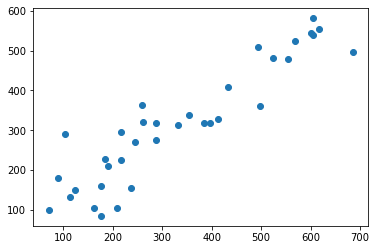

In [34]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(10):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_norm_I_max = XGBRegressor(max_depth=3, n_estimators=28, gamma=0.001, 
                   learning_rate=0.116, subsample=0.75, min_child_weight=6, 
                  random_state=random_state)
    # xgbr_norm_I_max = linear_model.BayesianRidge()
    # xgbr_norm_I_max = XGBRegressor()
    # Train the model on training data
    labels = Norm_I_Max
    xgbr_norm_I_max.fit(train_new_features, train_labels);
    
    Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)

    test_labels_ = test_labels.reshape(test_labels.shape[0], )

    Norm_I_Max_test_ = Norm_I_Max_test.reshape(Norm_I_Max_test.shape[0], )

    r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)
    r_pearsons.append(r_pearson_Norm_I_Max_test[0])
    r_squareds.append(r_squared_Norm_I_Max_test)
    
    Norm_I_Max_train = xgbr_norm_I_max.predict(train_new_features)
    r_squared_Norm_I_Max_train = r2_score(train_labels, Norm_I_Max_train)
    r_squareds_train.append(r_squared_Norm_I_Max_train)    
r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)
print (r_pearson_Norm_I_Max_test)
plt.scatter(test_labels_, Norm_I_Max_test_)
print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))



xgbr_norm_I_max.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_I_Max_predicted - Norm_I_Max)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_I_Max_all = r2_score(Norm_I_Max, Norm_I_Max_predicted)
print('r2 score = ', r_squared_Norm_I_Max_all)

# Use the forest's predict method on the test data
Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_I_Max_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
print('r2 score = ', r_squared_Norm_I_Max_test)

In [35]:
# Get numerical feature importances
importances = list(xgbr_norm_I_max.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

Variable: charge_denisty Importance: ('charge_denisty', 0.04)
Variable: PulseTime Importance: ('PulseTime', 0.03)
Variable: material_CB Importance: ('material_CB', 0.06)
Variable: material_MC Importance: ('material_MC', 0.73)
Variable: material_PA Importance: ('material_PA', 0.03)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.0)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.0)
Variable: Atmosphere_vac Importance: ('Atmosphere_vac', 0.1)


In [36]:
# proxy (current-time plot) prediction (Norm_charge_tot)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=9
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_charge_tot, 
                                       indices, test_size = 0.20, random_state = rand)
feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Atmosphere_vac',
                'Pretreat_voltage']

In [37]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(50):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_norm_charge_total = XGBRegressor(max_depth=3, n_estimators=28, gamma=0.01, 
                   learning_rate=0.116, subsample=0.75, min_child_weight=6, 
                  random_state=random_state)
    # xgbr_norm_charge_total = linear_model.BayesianRidge()
    # xgbr_norm_charge_total = XGBRegressor()
    # Train the model on training data
    labels = Norm_charge_tot
    xgbr_norm_charge_total.fit(train_new_features, train_labels);
    #print('Doneskies')
    Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    r_squareds.append(r_squared_Norm_charge_tot_test)
    
    test_labels_ = test_labels.reshape(test_labels.shape[0], )
    Norm_charge_tot_test_ = Norm_charge_tot_test.reshape(Norm_charge_tot_test.shape[0], )
    r_pearson_Norm_charge_tot_test = pearsonr(test_labels_, Norm_charge_tot_test_)
    r_pearsons.append(r_pearson_Norm_charge_tot_test[0])

    
    Norm_charge_tot_train = xgbr_norm_charge_total.predict(train_new_features)
    r_squared_Norm_charge_tot_train = r2_score(train_labels, Norm_charge_tot_train)
    r_squareds_train.append(r_squared_Norm_charge_tot_train)    

print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))


xgbr_norm_charge_total.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_charge_tot_predicted - Norm_charge_tot)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_charge_tot_all = r2_score(Norm_charge_tot, Norm_charge_tot_predicted)
print('r2 score = ', r_squared_Norm_charge_tot_all)

# Use the forest's predict method on the test data
Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_charge_tot_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
print('r2 score = ', r_squared_Norm_charge_tot_test)

Average of pearson r for test 0.6996058291621224
std of pearson 1 for test 0.020725025868674873 

Average of r_squared for test 0.4756160555824475
std of r_squared for test 0.02779007273902078 

Average of r_squared for train 0.7089506351791509
std of r_squared for train 0.008980003715967303
Mean Absolute Error: 29.8406 units.
r2 score =  0.7112441443181463
Mean Absolute Error: 33.2547 units.
r2 score =  0.7380678571587413


In [38]:
# Get numerical feature importances
importances = list(xgbr_norm_charge_total.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

Variable: charge_denisty Importance: ('charge_denisty', 0.26)
Variable: PulseTime Importance: ('PulseTime', 0.28)
Variable: material_CB Importance: ('material_CB', 0.07)
Variable: material_MC Importance: ('material_MC', 0.18)
Variable: material_PA Importance: ('material_PA', 0.06)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.0)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.0)
Variable: Atmosphere_vac Importance: ('Atmosphere_vac', 0.16)


In [39]:
heat_power = np.array (df['Voltage']*df['Voltage']/df['Init_R']*df['PulseTime']).reshape(-1, 1)
# Porxy properties, as well as process parameters
new_features = np.concatenate ((charge_denisty, 
                                material_type, 
                                pulsetime,
                                Pretreat_voltage,
                                atmosphere_type,
                                Final_Current_Percent_predicted.reshape(-1, 1),
                                Norm_I_Max_predicted.reshape(-1, 1),
                                Norm_charge_tot_predicted.reshape(-1, 1)), axis=1)
#                                heat_power.reshape(-1, 1)), axis=1)

rand=9
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Graphene_Yield, 
                                       indices, test_size = 0.20, random_state = rand)

feature_list = ['charge_denisty',
                'material_CB',
                'material_MC',
                'material_PA',
                'PulseTime',
                'Pretreat_voltage',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Atmosphere_vac',
                'Final_Current_Percent',
                'Norm_I_Max',
                'Norm_charge_tot',
                'heat_power']

In [29]:
# Grid Search CV each fit takes 1Sec, 5CV means running 5 times for each possibility
start = time.time()
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(
        estimator=XGBRegressor(),
        param_grid={
            'max_depth': [3],
            'n_estimators': [24],
            'min_child_weight': [5],
            'learning_rate': np.linspace(0.11, 0.12, 4),
            'subsample': [0.7],
            'gamma': [0.0001]
        },
        cv=5, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
grid_result = gsc.fit(train_new_features, train_labels)
best_params = grid_result.best_params_
print('Max Depth: ', best_params["max_depth"])
print('N Estimators: ', best_params["n_estimators"])
print('Min Child Weight: ', best_params["min_child_weight"])
print('Learning Rate: ', best_params["learning_rate"])
print('Subsample: ', best_params["subsample"])
print('Gamma: ', best_params["gamma"])
end = time.time()
print ('total time is {}'.format(end-start))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is d

Max Depth:  3
N Estimators:  24
Min Child Weight:  5
Learning Rate:  0.11333333333333333
Subsample:  0.7
Gamma:  0.0001
total time is 22.588096380233765


In [51]:
r_squareds = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(50):
    # Instantiate model with 1000 decision trees
    xgbr_graphyield = XGBRegressor(max_depth=3, n_estimators=38, gamma=0.001, 
                   learning_rate=0.09, subsample=0.75, min_child_weight=4, 
                   random_state=random_state)
    # Train the model on training data
    xgbr_graphyield.fit(train_new_features, train_labels);
    # Use the forest's predict method on the test data
    predictions = xgbr_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    errors = abs(predictions - test_labels)
    MAEs.append(errors)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

    r_squared = r2_score(test_labels, predictions)
    r_squareds.append (r_squared)
    
    pred_train = xgbr_graphyield.predict(train_new_features)
    errors = abs(pred_train - train_labels)
    MAEs_train.append(errors)
    r_squared = r2_score(train_labels, pred_train)
    r_squareds_train.append(r_squared)
    #print('r2 score = ', r_squared)

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))
# train accuracy
pred_train = xgbr_graphyield.predict(train_new_features)

# Calculate the absolute errors
errors_train = abs(pred_train - train_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')

r_squared_train = r2_score(train_labels, pred_train)
print('r2 score = ', r_squared_train)
end = time.time()
print ('time is: ', end-start)

Average of r_squared for test 0.7656130257500763
std of r_squared for test 0.014398749487385525 

Average of r_squared for train 0.8219535564129944
std of r_squared for train 0.004937284264500504
Mean Absolute Error: 28.0162 units.
r2 score =  0.8147570496074349
time is:  5.6480231285095215


(-0.39489014706615255, 7.597257773887351e-08)

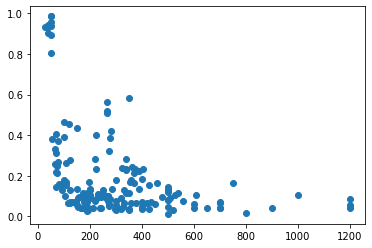

In [44]:
plt.scatter(pulsetime, Final_Current_Percent_predicted)

pulsetime_ = pulsetime.reshape(pulsetime.shape[0], )
Final_Current_Percent_predicted_ = Final_Current_Percent_predicted.reshape(
                                   Final_Current_Percent_predicted.shape[0], )

pearsonr(pulsetime_, Final_Current_Percent_predicted_)

(-0.2525116100383402, 0.0008032370563795286)

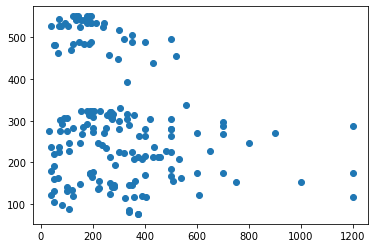

In [32]:
plt.scatter(pulsetime, Norm_I_Max_predicted)

pulsetime_ = pulsetime.reshape(pulsetime.shape[0], )
Norm_I_Max_predicted_ = Norm_I_Max_predicted.reshape(
                                   Norm_I_Max_predicted.shape[0], )

pearsonr(pulsetime_, Norm_I_Max_predicted_)

(0.4730123737499385, 4.97968076075472e-11)

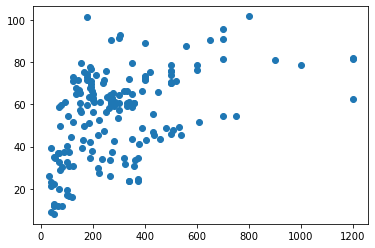

In [33]:
plt.scatter(pulsetime, Norm_charge_tot_predicted)

pulsetime_ = pulsetime.reshape(pulsetime.shape[0], )
Norm_charge_tot_predicted_ = Norm_charge_tot_predicted.reshape(
                                   Norm_charge_tot_predicted.shape[0], )

pearsonr(pulsetime_, Norm_charge_tot_predicted_)

In [34]:
df_currenttime

,Sample,Mass,Pretreat_voltage,Pretreat_highest,Voltage,PulseTime,Res_Volt,Cap,Init_R,Fin_R,...,Atmosphere_air,Atmosphere_arg,Atmosphere_vac,Norm_charge_tot,Norm_I_Max,charge_density,Final_Current_Percent,heat_power,materialgroup,ID
0,1,200.0,60.0,60.0,235.0,1200.0,56.0,96.0,1.6,0.4,...,0,0,1,80.159727,746.820500,112.800000,0.063619,414.187500,CB,1
1,2,161.9,150.0,50.0,120.0,50.0,98.0,114.0,1.6,1.0,...,0,0,1,13.029621,547.293823,84.496603,0.990995,4.500000,CB,2
2,3,200.0,240.0,60.0,235.0,300.0,161.0,96.0,1.7,0.3,...,0,0,1,35.543043,443.034350,112.800000,0.158840,97.455882,CB,3
3,4,200.0,320.0,80.0,235.0,900.0,43.0,96.0,1.8,0.5,...,0,0,1,86.790377,513.726500,112.800000,0.099584,276.125000,CB,4
4,5,187.0,60.0,60.0,145.0,125.0,104.6,96.0,1.4,0.8,...,1,0,0,19.643746,375.748930,74.438503,0.216167,18.772321,CB,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,112,348.0,200.0,120.0,209.0,202.0,77.6,150.0,4.8,0.8,...,0,0,1,67.741729,1103.409483,90.086207,0.092858,18.382421,PA,169
170,113,310.0,210.0,110.0,196.0,179.0,56.1,114.0,6.7,1.1,...,0,0,1,58.474320,924.340645,72.077419,0.086653,10.263379,PA,170
171,114,245.0,300.0,100.0,204.0,305.0,23.2,186.0,4.7,0.6,...,0,0,1,118.980850,1882.346939,154.873469,0.024435,27.006128,PA,171
172,115,212.0,240.0,100.0,180.0,500.0,73.3,114.0,16.2,3.0,...,1,0,0,88.670641,1167.779717,96.792453,0.058311,10.000000,PA,172


In [35]:
df_currenttime2 = df_currenttime.loc[df_currenttime ['pulsetime']<750, :]

KeyError: 'pulsetime'

In [ ]:
pulsetime_ = pulsetime.reshape(pulsetime.shape[0], )
Final_Current_Percent_predicted_ = Final_Current_Percent_predicted.reshape(Final_Current_Percent_predicted.shape[0], )

pearsonr(pulsetime_, Final_Current_Percent_predicted_)

In [ ]:
# Get numerical feature importances
importances = list(xgbr_graphyield.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

In [ ]:
pred_test = xgbr_graphyield.predict(test_new_features)
errors_test= abs(pred_train - train_labels)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
# ax.set_xlim(20,105)
# ax.set_ylim(20,105)

# Predicted 2D/G
plt.plot(pred_test, test_labels, 
         linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Predicted', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Actual', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

In [ ]:
# Plot style
fig, ax = plt.subplots(figsize=(5,4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Import file
filename='FJH_ML_Final.csv'
df_test = import_file_noOneHot(filename)
# Create normalized I by category
norm1, norm2 = category_normalization_theonesyoualwaysuse(df_test)
df_test['Norm_I_Max'] = norm1
df_test['Norm_charge_tot'] = norm2
df_test['charge_density'] = df_test['Voltage']*df_test['Cap']/df_test['Mass']
# df_test['test_feature'] = (df_test['Voltage']/df_test['Mass'])#*df_test['PulseTime']
# df_test = df_test[df_test['TwoDtoG']<1.5]
# df_test = df_test[df_test['Graphene_Yield']>20]

# Cut dataframe to only the test set
df_test = df_test.iloc[idx_test]
df_test['y_pred'] = pred_test
df_test['y_true'] = test_labels

groups = df_test.groupby(['Material'])

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_pred, group.y_true, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_materialgroup.png', dpi=300)
plt.show()

In [ ]:
# Distribution of Graphene_yield with  CD density groups
cv = np.array (df_test['charge_density'])
Qs = np.quantile (cv, [0.25, 0.5, 0.75])

cv_class = cv
cv_class = np.where(cv <= Qs[0], 0, cv_class)
cv_class = np.where((cv > Qs[0]) & (cv <= Qs[1]), 1, cv_class)
cv_class = np.where((cv > Qs[1]) & (cv <= Qs[2]), 2, cv_class)
cv_class = np.where(cv > Qs[2], 3, cv_class)

# Plot style
fig, ax = plt.subplots(figsize=(5,4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)
df_test['cv_class'] = cv_class
groups = df_test.groupby(['cv_class'])

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_pred, group.y_true, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_cvgroup.png', dpi=300)
plt.show()

In [ ]:
# outside test (Need to ask Jacob the details, material, atmosphere)
filename = 'FJH_ML_MBO_Yield4_modified.csv'
df_testBO0 = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=1)
df_testBO = df_testBO0.loc[0:29, :]
# Only works for test that are TCB material !!!!!!
Material_TCB_testBO = np.array (df_testBO['Material']).reshape(-1, 1)
Material_TCB_testBO [:] = 1
Material_CB_testBO = np.zeros_like (Material_TCB_testBO)
Material_CB_testBO [:] = 0
Material_MC_testBO = np.zeros_like (Material_TCB_testBO)
Material_PA_testBO = np.zeros_like (Material_TCB_testBO)
material_type_testBO = np.concatenate ((Material_CB_testBO, 
                                        Material_MC_testBO, 
                                        Material_PA_testBO, 
                                        Material_TCB_testBO), axis=1)

Atmosphere_air_testBO = np.array (df_testBO['Atmosphere']).reshape(-1, 1)
Atmosphere_air_testBO [:] = 0
Atmosphere_arg_testBO = np.zeros_like (Atmosphere_air_testBO)
Atmosphere_vac_testBO = np.zeros_like (Atmosphere_air_testBO)
Atmosphere_vac_testBO [:] = 1
atmosphere_type_testBO = np.concatenate ((Atmosphere_air_testBO, 
                                          Atmosphere_arg_testBO, 
                                          Atmosphere_vac_testBO), axis=1)
# base 60mF as base and the number in excel file of 18mF
df_testBO['Cap'] = 60 + df_testBO['Cap']*18
charge_density_testBO = np.array (df_testBO['Voltage']*df_testBO['Cap']/df_testBO['Mass']).reshape(-1, 1)
pulsetime_testBO = np.array (df_testBO['PulseTime']).reshape(-1, 1)
Pretreat_voltage_testBO = np.array (df_testBO['Pretreat_voltage']).reshape(-1, 1)

# proxy prediction features
features_testBO = np.concatenate ((charge_density_testBO,
                                   material_type_testBO,
                                   atmosphere_type_testBO,
                                   pulsetime_testBO,
                                   Pretreat_voltage_testBO), axis=1)

In [ ]:
Final_Current_Percent_predicted_testBO = xgbr_final_I_percent.predict(features_testBO)
Norm_I_Max_predicted_testBO = xgbr_norm_I_max.predict(features_testBO)
Norm_charge_tot_testBO = xgbr_norm_charge_total.predict(features_testBO)

In [ ]:
# Porxy properties, as well as process parameters
features_testBO = np.concatenate ((charge_density_testBO,
                                   material_type_testBO,
                                   atmosphere_type_testBO,
                                   pulsetime_testBO,
                                   Pretreat_voltage_testBO,
                                   Final_Current_Percent_predicted_testBO.reshape(-1, 1),
                                   Norm_I_Max_predicted_testBO.reshape(-1, 1),
                                   Norm_charge_tot_testBO.reshape(-1, 1)), axis=1)

In [ ]:
graphene_yield_testBO = np.array (df_testBO['Graphene_Yield']).reshape(-1, 1)
graphene_yield_testBO = 100*graphene_yield_testBO
graphene_yield_testBO_predicted = xgbr_graphyield.predict (features_testBO)

r2_score(graphene_yield_testBO, graphene_yield_testBO_predicted)

In [ ]:
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
# ax.set_xlim(20,105)
# ax.set_ylim(20,105)

# Predicted 2D/G
plt.plot(graphene_yield_testBO_predicted, graphene_yield_testBO, 
         linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Predicted', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Actual', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

In [ ]:
# Plot pred vs. true values for test set, coloring the charge density
groups = df_test.groupby(['Material'])
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')


for name, group in groups:
    p = ax.scatter(group.y_pred, group.y_true, c=group.charge_density, marker='o', s=100, cmap='Blues')
    
cb = fig.colorbar(p, ax=ax)
cb.set_label('Charge Density (C/g)', fontsize='18', fontname='Arial', fontweight='bold')
cb.ax.tick_params(labelsize=14)

# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
# ax.legend(fontsize=12)

# Plot
# plt.plot(df['I_Max'],df['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
# plt.savefig('XGB_Regression_Performance_colorChargeDensity.png', dpi=300)
plt.show()